<a href="https://colab.research.google.com/github/Razankenawy7/seam/blob/main/seams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Seam Carving Time: 11.7872 seconds
Original Image:


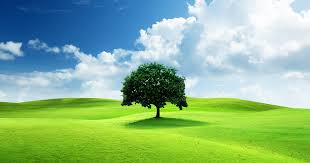

Seam Visualization:


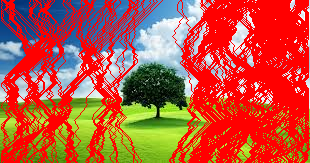

Resized Image After Seam Carving:


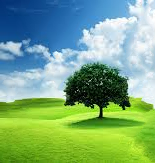

In [1]:
import numpy as np
from PIL import Image, ImageDraw
import time
from google.colab import drive
from IPython.display import display

drive.mount('/content/drive')

image_path = "/content/drive/My Drive/sora.jpg"

def load_image(image_path):
    return np.array(Image.open(image_path).convert("RGB"))

def compute_energy(image):
    gray = np.dot(image[..., :3], [0.299, 0.587, 0.114])
    dx = np.abs(np.roll(gray, -1, axis=1) - np.roll(gray, 1, axis=1))
    dy = np.abs(np.roll(gray, -1, axis=0) - np.roll(gray, 1, axis=0))
    return dx + dy

def visualize_seams(image, removed_seams):
    vis_img = Image.fromarray(image)
    draw = ImageDraw.Draw(vis_img)
    for (y, x) in removed_seams:
        draw.point((x, y), fill=(255, 0, 0))
    display(vis_img)

def find_vertical_seam(energy):
    h, w = energy.shape
    cum_energy = energy.copy()
    path = np.zeros((h, w), dtype=int)
    for i in range(1, h):
        for j in range(w):
            left = cum_energy[i-1, j-1] if j > 0 else np.inf
            mid = cum_energy[i-1, j]
            right = cum_energy[i-1, j+1] if j < w-1 else np.inf
            min_energy = min(left, mid, right)
            cum_energy[i, j] += min_energy
            path[i, j] = -1 if min_energy == left else (1 if min_energy == right else 0)
    seam = [np.argmin(cum_energy[-1])]
    for i in range(h-2, -1, -1):
        seam.append(seam[-1] + path[i+1, seam[-1]])
    return np.array(seam[::-1])

def remove_seam(image, seam):
    h, w = image.shape[:2]
    mask = np.ones((h, w), dtype=bool)
    mask[np.arange(h), seam] = False
    return image[mask].reshape((h, w - 1, 3)), mask

def remove_vertical_seams(image, target_width):
    h, w = image.shape[:2]
    coord_grid = np.stack(np.indices((h, w)), axis=-1)
    removed_seams = []
    start_time = time.time()

    while image.shape[1] > target_width:
        energy = compute_energy(image)
        seam = find_vertical_seam(energy)
        removed_seams.extend(coord_grid[np.arange(h), seam].tolist())
        image, mask = remove_seam(image, seam)
        coord_grid = coord_grid[mask].reshape((h, image.shape[1], 2))

    elapsed_time = time.time() - start_time
    print(f"Seam Carving Time: {elapsed_time:.4f} seconds")
    return image, removed_seams

def main():
    image = load_image(image_path)
    target_width = image.shape[1] // 2
    carved_image, removed_seams = remove_vertical_seams(image.copy(), target_width)
    print("Original Image:")
    display(Image.fromarray(image))
    print("Seam Visualization:")
    visualize_seams(image, removed_seams)
    print("Resized Image After Seam Carving:")
    display(Image.fromarray(carved_image))

if __name__ == "__main__":
    main()
